# 整合 Agent 與 MCP

In [1]:
%%capture
!pip install fastmcp

In [2]:
%%capture
!pip install -U langchain langchain-openai yfinance

## 1. 建立 MCP Server

In [3]:

from fastmcp import FastMCP, Client

app = FastMCP("finance-mcp")

@app.tool
def get_stock_price(symbol: str) -> str:
    """查詢股票價格"""
    return f"{symbol} 目前價格 1050 元，上漲 1.5%"

@app.tool
def analyze_trend(symbol: str) -> str:
    """分析股票趨勢"""
    return f"{symbol} 技術面：偏多，RSI 65"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 2. LangChain 呼叫 MCP Tools

In [78]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
import os

# 設定 API Key
os.environ["OPENAI_API_KEY"] = "sk-proj-"

llm = ChatOpenAI(model="gpt-4.1", temperature=0)


In [5]:
async def langchain_with_mcp(question: str):
    """LangChain + MCP 簡單整合"""

    print(f"問題: {question}\n")

    # Step 1: 用 LLM 判斷要用哪個工具
    decision = llm.invoke([
        SystemMessage(content="""判斷使用者問題需要哪個工具：
        - get_stock_price: 查詢股價
        - analyze_trend: 分析趨勢
        只回答工具名稱"""),
        HumanMessage(content=question)
    ])

    tool_name = decision.content.strip()
    print(f"選擇工具: {tool_name}")

    # Step 2: 提取股票代號
    symbol_response = llm.invoke([
        HumanMessage(content=f"從問題中提取股票代號: {question}\n只回答代號")
    ])
    symbol = symbol_response.content.strip()
    print(f"股票代號: {symbol}")

    # Step 3: 呼叫 MCP Tool
    async with Client(app) as client:
        result = await client.call_tool(tool_name, {"symbol": symbol})
        tool_result = result.content[0].text

    print(f"工具結果: {tool_result}")

    # Step 4: 用 LLM 生成最終回答
    final_answer = llm.invoke([
        HumanMessage(content=f"""問題: {question}
        工具結果: {tool_result}

        請用繁體中文整理回答（50字內）""")
    ])

    print(f"\n最終回答:\n{final_answer.content}")

    return final_answer.content

# 測試
await langchain_with_mcp("台積電現在股價多少？")

問題: 台積電現在股價多少？

🔧 選擇工具: get_stock_price
📊 股票代號: 2330
🔨 工具結果: 2330 目前價格 1050 元，上漲 1.5%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



💬 最終回答:
台積電（2330）目前股價為1050元，上漲1.5%。


'台積電（2330）目前股價為1050元，上漲1.5%。'

# 動態工具整合

## 1. MCP Server（可以隨時增加工具）

In [6]:
from fastmcp import FastMCP, Client
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
import os
import json
import re

app = FastMCP("finance-mcp")

# 初始工具
@app.tool
def get_stock_price(symbol: str) -> str:
    """查詢股票價格"""
    return f"{symbol} 目前價格 1050 元，上漲 1.5%"

@app.tool
def analyze_trend(symbol: str) -> str:
    """分析股票趨勢"""
    return f"{symbol} 技術面：偏多，RSI 65"

# 隨時可以新增工具
@app.tool
def get_news(symbol: str) -> str:
    """查詢股票新聞"""
    return f"{symbol} 最新消息：宣布新產品發布"

@app.tool
def calculate_pe_ratio(symbol: str, eps: float, price: float) -> str:
    """計算本益比"""
    pe = price / eps
    return f"{symbol} 本益比為 {pe:.2f}"


## 2. 動態 LangChain 整合

In [8]:
async def langchain_with_mcp_dynamic(question: str):
    """LangChain + MCP 動態整合"""

    # Step 1: 動態獲取所有可用工具
    async with Client(app) as client:
        tools = await client.list_tools()

    # 建立工具列表提示
    tools_prompt = "可用工具:\n"
    for i, tool in enumerate(tools, 1):
        params = tool.inputSchema.get("properties", {}) if tool.inputSchema else {}
        param_names = ", ".join(params.keys())
        tools_prompt += f"{i}. {tool.name}({param_names}) - {tool.description}\n"

    # Step 2: LLM 決定使用哪個工具和參數
    decision_prompt = f"""{tools_prompt}

    使用者問題: {question}

    請選擇最適合的工具並提取參數。
    用 JSON 格式回答:
    {{"tool": "工具名稱", "params": {{"參數名": "值"}}}}

    只回答 JSON，不要其他內容。"""

    decision = llm.invoke([HumanMessage(content=decision_prompt)])

    # 解析 JSON（處理可能的 markdown 包裝）
    response_text = decision.content.strip()
    response_text = re.sub(r'```json\s*|\s*```', '', response_text)

    try:
        decision_data = json.loads(response_text)
        tool_name = decision_data["tool"]
        params = decision_data["params"]
    except Exception as e:
        print(f"解析失敗: {e}")
        print(f"原始回應:\n{response_text}")
        return None

    print(f"選擇工具: {tool_name}")
    print(f"參數: {params}")

    # Step 3: 呼叫 MCP 工具
    async with Client(app) as client:
        result = await client.call_tool(tool_name, params)
        tool_result = result.content[0].text

    print(f"工具結果: {tool_result}")

    # Step 4: LLM 生成最終回答
    final_prompt = f"""問題: {question}
    工具結果: {tool_result}

    請用繁體中文整理成自然的回答（50字內）"""

    final_answer = llm.invoke([HumanMessage(content=final_prompt)])

    print(f"\n最終回答:\n{final_answer.content}")

    return final_answer.content



## 3. 測試不同問題

In [10]:
async def demo():
    print("="*70)
    print("LangChain 動態呼叫 MCP Tools")
    print("="*70 + "\n")

    # 測試 1: 自動選擇 get_stock_price
    await langchain_with_mcp_dynamic("台積電現在股價多少？")

    print("\n" + "="*70 + "\n")

    # 測試 2: 自動選擇 analyze_trend
    await langchain_with_mcp_dynamic("2330 的技術面如何？")

    print("\n" + "="*70 + "\n")

    # 測試 3: 自動選擇新增的 get_news
    await langchain_with_mcp_dynamic("台積電有什麼新消息？")

    print("\n" + "="*70 + "\n")

    # 測試 4: 自動選擇 calculate_pe_ratio
    await langchain_with_mcp_dynamic("台積電 EPS 35，價格 1050，本益比多少？")

await demo()

LangChain 動態呼叫 MCP Tools



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


選擇工具: get_stock_price
參數: {'symbol': '2330'}
工具結果: 2330 目前價格 1050 元，上漲 1.5%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



最終回答:
台積電（2330）目前股價為1050元，上漲1.5%。




/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


選擇工具: analyze_trend
參數: {'symbol': '2330'}
工具結果: 2330 技術面：偏多，RSI 65


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



最終回答:
2330 技術面偏多，RSI為65，顯示多頭動能較強，短線走勢樂觀。




/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


選擇工具: get_news
參數: {'symbol': 'TSMC'}
工具結果: TSMC 最新消息：宣布新產品發布


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



最終回答:
台積電近日宣布推出新產品，展現持續創新能力，強化其在半導體產業的領先地位。




/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


選擇工具: calculate_pe_ratio
參數: {'symbol': '台積電', 'eps': 35, 'price': 1050}
工具結果: 台積電 本益比為 30.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



最終回答:
台積電每股盈餘為35元，股價1050元，本益比約為30倍。


# 整合 LangGraph 與 MCP Tools

## 1. MCP Server 定義工具

In [11]:
from fastmcp import FastMCP, Client
import yfinance as yf

app = FastMCP("finance-mcp")

@app.tool
def get_stock_price(symbol: str) -> str:
    """
    查詢股票最新價格和今日漲跌。

    參數:
        symbol: 股票代碼或名稱 (例如: 2330, 台積電, 0050)
    """
    s = symbol.strip()

    name_to_code = {
        "台積電": "2330.TW",
        "鴻海": "2317.TW",
        "聯發科": "2454.TW",
        "0050": "0050.TW",
        "0056": "0056.TW",
    }

    if s in name_to_code:
        s = name_to_code[s]
    elif s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)
        hist = ticker.history(period='2d')

        if hist.empty:
            return f"查無 {symbol} 的資料"

        latest_price = hist['Close'].iloc[-1]
        open_price = hist['Open'].iloc[-1]
        change = latest_price - open_price
        change_pct = (change / open_price) * 100

        return f"""✅ {symbol}({s})
            最新價: {latest_price:.2f} 元
            今日漲跌: {change:+.2f} 元 ({change_pct:+.2f}%)"""

    except Exception as e:
        return f"查詢失敗: {str(e)}"

@app.tool
def analyze_30d_ma_trend(symbol: str) -> str:
    """
    使用 30 日均線判斷目前偏多頭、偏空頭或震盪。

    參數:
        symbol: 股票代碼或名稱 (例如: 2330, 台積電)
    """
    s = symbol.strip()

    name_to_code = {
        "台積電": "2330.TW",
        "鴻海": "2317.TW",
        "聯發科": "2454.TW",
        "0050": "0050.TW",
    }

    if s in name_to_code:
        s = name_to_code[s]
    elif s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)
        hist = ticker.history(period="60d")

        if len(hist) < 30:
            return f"{symbol} 資料不足,無法計算 30 日均線"

        closes_30 = hist["Close"].tail(30)
        ma30 = float(closes_30.mean())
        latest = float(closes_30.iloc[-1])

        diff_pct = (latest - ma30) / ma30 * 100

        if diff_pct >= 2:
            trend = "偏多頭"
            comment = "股價在均線之上,目前趨勢偏多"
        elif diff_pct <= -2:
            trend = "偏空頭"
            comment = "股價在均線之下,目前趨勢偏空"
        else:
            trend = "震盪整理"
            comment = "股價貼近均線,處於盤整狀態"

        return f"""{symbol}({s}) 30日均線分析:
            目前價格: {latest:.2f} 元
            30日均線: {ma30:.2f} 元
            乖離率: {diff_pct:+.2f}%
            趨勢判斷: {trend}
            說明: {comment}"""

    except Exception as e:
        return f"分析失敗: {str(e)}"

@app.tool
def calculate_etf_yield(symbol: str) -> str:
    """
    計算 ETF 的殖利率(根據近一年配息)。

    參數:
        symbol: ETF 代碼 (例如: 0056, 00878)
    """
    s = symbol.strip()

    if s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)
        dividends = ticker.dividends

        if dividends.empty:
            return f"{symbol} 無配息資料"

        import pandas as pd

        # 修正：處理時區問題
        one_year_ago = pd.Timestamp.now(tz='UTC') - pd.DateOffset(years=1)

        # 確保 dividends 索引也有時區
        if dividends.index.tz is None:
            dividends.index = dividends.index.tz_localize('UTC')
        else:
            dividends.index = dividends.index.tz_convert('UTC')

        recent_dividends = dividends[dividends.index > one_year_ago]

        if recent_dividends.empty:
            return f"{symbol} 近一年無配息紀錄"

        total_dividend = recent_dividends.sum()
        hist = ticker.history(period='1d')
        current_price = hist['Close'].iloc[-1]
        dividend_yield = (total_dividend / current_price) * 100

        return f"""{symbol} 殖利率分析:
            目前價格: {current_price:.2f} 元
            近一年配息: {total_dividend:.2f} 元
            殖利率: {dividend_yield:.2f}%"""

    except Exception as e:
        return f"計算失敗: {str(e)}"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 2. LangGraph 整合 MCP

In [12]:
from typing import TypedDict, Optional, List
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
import os

In [13]:
# 定義 State
class ToolAgentState(TypedDict):
    user_id: str
    text: str
    tool_calls: Optional[List[str]]
    tool_results: Optional[List[str]]
    answer: Optional[str]

In [14]:
# Node 1: 決定使用哪些工具（動態從 MCP 獲取）
async def plan_tools_node(state: ToolAgentState) -> ToolAgentState:
    """分析問題，決定需要使用哪些 MCP 工具"""
    user_text = state["text"]

    print(f"\n使用者問題: {user_text}")
    print(f"分析需要使用的工具...")

    # 動態獲取 MCP 工具列表
    async with Client(app) as client:
        tools = await client.list_tools()

    # 建立工具描述
    tools_desc = ""
    for i, tool in enumerate(tools, 1):
        tools_desc += f"{i}. {tool.name} - {tool.description}\n"

    # 使用 LLM 判斷需要哪些工具
    prompt = f"""你是金融工具規劃專家。分析使用者問題，判斷需要使用哪些工具。

    可用的 MCP 工具:
    {tools_desc}

    使用者問題: {user_text}

    請只回答需要的工具名稱，用逗號分隔。如果不需要工具，回答 "none"。
    範例回答: "get_stock_price,analyze_30d_ma_trend" 或 "none"

    回答:"""

    response = llm.invoke([{"role": "user", "content": prompt}])
    tools_needed = response.content.strip().lower()

    if tools_needed == "none":
        state["tool_calls"] = []
        print("不需要使用工具，直接回答")
    else:
        state["tool_calls"] = [t.strip() for t in tools_needed.split(",")]
        print(f"需要使用工具: {', '.join(state['tool_calls'])}")

    return state


In [17]:
# Node 2: 執行 MCP 工具
async def execute_tools_node(state: ToolAgentState) -> ToolAgentState:
    """執行 MCP 工具並收集結果"""
    tool_calls = state.get("tool_calls", [])
    user_text = state["text"]

    if not tool_calls:
        state["tool_results"] = []
        return state

    print(f"\n執行 MCP 工具中...")

    # 提取股票代碼
    extract_prompt = f"""從問題中提取股票代碼或名稱。
     問題: {user_text}
     只回答股票代碼或名稱，例如: "2330" 或 "台積電" 或 "0056"
     回答:"""

    response = llm.invoke([{"role": "user", "content": extract_prompt}])
    symbol = response.content.strip()
    print(f"識別股票: {symbol}")

    # 執行 MCP 工具
    results = []
    async with Client(app) as client:
        for tool_name in tool_calls:
            print(f"執行 {tool_name}...")

            try:
                result = await client.call_tool(tool_name, {"symbol": symbol})
                results.append(result.content[0].text)
                print(f"完成")
            except Exception as e:
                error_msg = f"工具執行失敗: {str(e)}"
                results.append(error_msg)
                print(f"失敗: {e}")

    state["tool_results"] = results

    # 顯示結果
    print(f"\n工具執行結果:")
    for i, result in enumerate(results, 1):
        print(f"\n--- 工具 {i} ---")
        print(result)

    return state



In [18]:
# Node 3: 生成回答
def answer_node(state: ToolAgentState) -> ToolAgentState:
    """整合工具結果，生成最終回答"""
    user_text = state["text"]
    tool_results = state.get("tool_results", [])

    print(f"\n生成回答中...")

    # 準備 context
    if tool_results:
        context = "\n\n".join([f"【工具結果 {i+1}】\n{result}"
                               for i, result in enumerate(tool_results)])
    else:
        context = "無工具資料"

    # 生成回答
    system_prompt = """你是專業金融客服。根據工具提供的資料回答使用者問題。

    重要規則:
    1. 用白話文解釋數據
    2. 適時提醒投資風險
    3. 不要只是複述數據，要加上分析
    4. 保持專業但親切的語氣
    5. 150字內"""

    user_prompt = f"""使用者問題: {user_text}

    工具提供的資料:
    {context}

    請根據以上資料回答使用者問題。"""

    msgs = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    response = llm.invoke(msgs)
    state["answer"] = response.content

    return state

## 3. 建立 LangGraph

In [19]:
graph = StateGraph(ToolAgentState)

# 加入節點
graph.add_node("plan_tools", plan_tools_node)
graph.add_node("execute_tools", execute_tools_node)
graph.add_node("answer", answer_node)

# 線性流程
graph.set_entry_point("plan_tools")
graph.add_edge("plan_tools", "execute_tools")
graph.add_edge("execute_tools", "answer")
graph.add_edge("answer", END)

# 編譯
workflow = graph.compile()



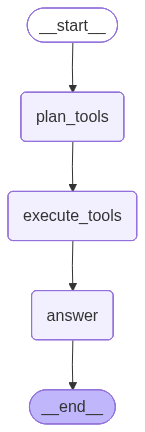

In [20]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

## 4. 測試

In [21]:
async def test_mcp_langgraph():
    test_cases = [
        {
            "user_id": "user_001",
            "text": "台積電今天股價多少？",
            "tool_calls": None,
            "tool_results": None,
            "answer": None
        },
        {
            "user_id": "user_002",
            "text": "幫我分析 2330 的 30 日均線趨勢",
            "tool_calls": None,
            "tool_results": None,
            "answer": None
        },
        {
            "user_id": "user_003",
            "text": "0056 的殖利率如何？",
            "tool_calls": None,
            "tool_results": None,
            "answer": None
        },
    ]

    for i, case in enumerate(test_cases, 1):
        print("="*70)
        print(f"🧪 測試案例 {i}")
        print("="*70)

        result = await workflow.ainvoke(case)

        print(f"\n✅ 最終回答:\n{result['answer']}\n")

await test_mcp_langgraph()

🧪 測試案例 1

使用者問題: 台積電今天股價多少？
分析需要使用的工具...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


需要使用工具: get_stock_price

執行 MCP 工具中...
識別股票: 台積電
執行 get_stock_price...
完成

工具執行結果:

--- 工具 1 ---
✅ 台積電(2330.TW)
            最新價: 1375.00 元
            今日漲跌: -25.00 元 (-1.79%)

生成回答中...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✅ 最終回答:
台積電今天的股價是1375元，比昨天跌了25元，跌幅約1.79%。這表示市場對台積電短期有些壓力，可能受到整體大盤或產業消息影響。提醒您，股價波動屬於正常現象，投資前建議多關注相關資訊並評估自身風險承受度。

🧪 測試案例 2

使用者問題: 幫我分析 2330 的 30 日均線趨勢
分析需要使用的工具...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


需要使用工具: analyze_30d_ma_trend

執行 MCP 工具中...
識別股票: 2330
執行 analyze_30d_ma_trend...
完成

工具執行結果:

--- 工具 1 ---
2330(2330.TW) 30日均線分析:
            目前價格: 1375.00 元
            30日均線: 1458.00 元
            乖離率: -5.69%
            趨勢判斷: 偏空頭
            說明: 股價在均線之下,目前趨勢偏空

生成回答中...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✅ 最終回答:
目前台積電（2330）的股價在1375元，低於30日均線的1458元，乖離率為-5.69%，代表股價明顯落在均線下方，短期趨勢偏空。這表示市場氣氛較保守，短線上可能還有壓力。建議投資時要注意風險，避免追高，並觀察後續是否有止跌回穩的跡象。

🧪 測試案例 3

使用者問題: 0056 的殖利率如何？
分析需要使用的工具...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


需要使用工具: calculate_etf_yield

執行 MCP 工具中...
識別股票: 0056
執行 calculate_etf_yield...
完成

工具執行結果:

--- 工具 1 ---
0056 殖利率分析:
            目前價格: 35.13 元
            近一年配息: 3.87 元
            殖利率: 11.02%

生成回答中...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✅ 最終回答:
0056 目前的殖利率約為 11.02%，代表以現在價格買進，每年可望拿到約 11% 的現金股息，這在台股高股息ETF中算是相當不錯的水準。不過，殖利率高有時也反映市場對未來成長的疑慮，建議您除了看殖利率，也要留意股價波動及配息穩定性，分散投資會更安心。



# 練習題 5.動態新增工具

In [ ]:
@app.tool
def get_technical_indicators(symbol: str) -> str:
    """
    查詢股票的技術指標

    參數:
        symbol: 股票代碼

    回傳:
        RSI, MACD, KD 等技術指標
    """

# 完整金融語音助理

## 1. MCP Server - 工具定義

In [79]:
from fastmcp import FastMCP, Client
import yfinance as yf

app = FastMCP("finance-assistant")

@app.tool
def get_stock_price(symbol: str) -> str:
    """查詢即時股價"""
    s = symbol.strip()
    if s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)
        hist = ticker.history(period='1d')
        price = hist['Close'].iloc[-1]
        return f"{symbol} 目前價格: {price:.2f} 元"
    except:
        return f"查詢失敗: {symbol}"

@app.tool
def analyze_risk(symbol: str, amount: float) -> str:
    """風險評估"""
    if amount > 100000:
        return f"⚠️ 高風險：投資 {symbol} 金額 {amount:,.0f} 元超過建議上限"
    else:
        return f"✅ 風險可控：投資 {symbol} 金額 {amount:,.0f} 元在合理範圍"

@app.tool
def execute_trade(symbol: str, amount: float) -> str:
    """模擬交易執行"""
    return f"✅ 已下單：買入 {symbol}，金額 {amount:,.0f} 元"

## 2. LangGraph - 完整流程

In [80]:
from typing import TypedDict, Optional, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
import os
import re


# 定義 State（新增 audio_output）
class State(TypedDict):
    # 用戶輸入
    audio_path: str
    raw_text: Optional[str]
    normalized_text: Optional[str]

    # Memory
    user_id: str
    user_profile: Optional[dict]

    # Orchestrator
    intent: Optional[str]

    # Tool 相關
    tool_results: Optional[str]

    # Human-in-the-loop
    human_approved: Optional[bool]

    # 最終結果
    answer: Optional[str]
    audio_output: Optional[str]  # 🆕 TTS 輸出路徑


## Memory 管理

In [81]:
USER_MEMORY = {
    "user_001": {"name": "張三", "risk_level": "保守", "max_investment": 50000},
    "user_002": {"name": "李四", "risk_level": "積極", "max_investment": 200000}
}

def load_memory_node(state: State) -> State:
    """載入用戶記憶"""
    user_id = state["user_id"]
    state["user_profile"] = USER_MEMORY.get(user_id, {
        "name": "訪客", "risk_level": "保守", "max_investment": 10000
    })
    print(f"📚 載入記憶: {state['user_profile']['name']} ({state['user_profile']['risk_level']})")
    return state


## Pipeline: STT → 標準化

In [82]:
%%capture
!pip install ffmpeg-python

In [83]:
#@markdown 取得錄音資訊
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [84]:
from IPython.display import Audio
from openai import OpenAI
client = OpenAI()

def listenTo():
  audio, rate = get_audio()
  ad = Audio(audio, rate=rate)
  audio_file = '/content/test.wav'
  with open(audio_file, 'wb') as f:
      f.write(ad.data)
  audio_ = open(audio_file, "rb")
  transcript = client.audio.transcriptions.create(
    model="gpt-4o-mini-transcribe",
    file=audio_
  )
  return transcript.text

In [85]:
def stt_node(state: State) -> State:
    """STT 語音轉文字"""

    state["raw_text"] = listenTo()
    print(f"🎤 STT: {state['raw_text']}")
    return state

def normalize_node(state: State) -> State:
    """金融詞彙標準化"""
    text = state["raw_text"]
    replacements = {"台積電": "2330", "二三三零": "2330", "鴻海": "2317"}
    for old, new in replacements.items():
        text = text.replace(old, new)

    state["normalized_text"] = text
    print(f"📝 標準化: {state['normalized_text']}")
    return state

## Orchestrator: 意圖分類

In [86]:
def orchestrator_node(state: State) -> State:
    """判斷用戶意圖"""
    text = state["normalized_text"]

    prompt = f"""判斷用戶意圖：
    問題: {text}

    意圖類型:
    - query: 單純查詢股價
    - analysis: 需要分析
    - trade: 想要交易

    只回答: query, analysis, 或 trade"""

    response = llm.invoke([{"role": "user", "content": prompt}])
    state["intent"] = response.content.strip().lower()
    print(f"🎯 意圖: {state['intent']}")
    return state

def route_by_intent(state: State) -> Literal["query_branch", "analysis_branch", "trade_branch"]:
    """路由到不同分支"""
    intent_map = {
        "query": "query_branch",
        "analysis": "analysis_branch",
        "trade": "trade_branch"
    }
    return intent_map.get(state["intent"], "query_branch")

# ============================================================
# 三個分支
# ============================================================
async def query_branch(state: State) -> State:
    """查詢股價分支"""
    print(f"🔍 執行查詢分支")
    symbol = re.search(r'\d{4}', state["normalized_text"])
    symbol = symbol.group(0) if symbol else "2330"

    async with Client(app) as client:
        result = await client.call_tool("get_stock_price", {"symbol": symbol})
        state["tool_results"] = result.content[0].text

    print(f"📊 查詢結果: {state['tool_results']}")
    return state

async def analysis_branch(state: State) -> State:
    """分析分支"""
    print(f"📈 執行分析分支")
    symbol = re.search(r'\d{4}', state["normalized_text"])
    symbol = symbol.group(0) if symbol else "2330"

    async with Client(app) as client:
        price_result = await client.call_tool("get_stock_price", {"symbol": symbol})
        state["tool_results"] = f"""分析報告:
{price_result.content[0].text}

建議: 根據用戶風險等級({state['user_profile']['risk_level']})，建議謹慎評估"""

    print(f"📊 分析完成")
    return state

async def trade_branch(state: State) -> State:
    """交易分支"""
    print(f"💰 執行交易分支")
    symbol = re.search(r'\d{4}', state["normalized_text"])
    symbol = symbol.group(0) if symbol else "2330"

    amount_match = re.search(r'(\d+)萬', state["normalized_text"])
    amount = int(amount_match.group(1)) * 10000 if amount_match else 10000

    async with Client(app) as client:
        risk_result = await client.call_tool("analyze_risk", {
            "symbol": symbol, "amount": float(amount)
        })
        state["tool_results"] = risk_result.content[0].text

    max_invest = state["user_profile"]["max_investment"]
    if amount > max_invest:
        state["tool_results"] += f"\n\n⚠️ 超過您的投資上限 {max_invest:,.0f} 元"
        state["human_approved"] = False

    print(f"⚠️ 風險評估: {state['tool_results']}")
    return state

## Human-in-the-loop

In [87]:
def human_approval_node(state: State) -> State:
    """人工確認"""
    print(f"\n{'='*60}")
    print(f"🤚 需要人工確認")
    print(f"用戶: {state['user_profile']['name']}")
    print(f"風險評估:\n{state['tool_results']}")
    print(f"{'='*60}")

    user_input = input("是否批准？(y/n): ")
    state["human_approved"] = user_input.lower() == 'y'

    if state["human_approved"]:
        print("✅ 人工批准")
    else:
        print("❌ 人工拒絕")

    return state

def need_human_approval(state: State) -> Literal["human_approval", "execute_action"]:
    """判斷是否需要人工確認"""
    return "human_approval" if state["intent"] == "trade" else "execute_action"

## 執行動作

In [88]:
async def execute_action(state: State) -> State:
    """執行最終動作"""
    if state["intent"] == "trade" and state.get("human_approved"):
        symbol = re.search(r'\d{4}', state["normalized_text"]).group(0)
        amount_match = re.search(r'(\d+)萬', state["normalized_text"])
        amount = int(amount_match.group(1)) * 10000 if amount_match else 10000

        async with Client(app) as client:
            trade_result = await client.call_tool("execute_trade", {
                "symbol": symbol, "amount": float(amount)
            })
            state["tool_results"] += f"\n\n{trade_result.content[0].text}"

    return state

## 生成回覆

In [89]:
def answer_node(state: State) -> State:
    """生成最終回覆"""
    user_name = state["user_profile"]["name"]

    prompt = f"""用戶: {user_name}
        問題: {state['normalized_text']}
        工具結果: {state['tool_results']}

        請生成友善的回覆（50字內）"""

    response = llm.invoke([{"role": "user", "content": prompt}])
    state["answer"] = response.content

    print(f"\n💬 文字回覆: {state['answer']}")
    return state

## TTS: 文字轉語音

In [90]:
def TextToSpeech(text):
  with client.audio.speech.with_streaming_response.create(
    model="gpt-4o-mini-tts",
    voice="alloy",
    input=text
  ) as response:
    response.stream_to_file('tts.mp3')

In [104]:
from IPython.display import Audio, display

def tts_node(state: State) -> State:
    """TTS 文字轉語音"""
    print(f"\n🔊 TTS 轉換中...")

    try:
        text = state["answer"]
        TextToSpeech(text)
        display(Audio('tts.mp3', autoplay=True))

    except Exception as e:
        print(f"❌ TTS 失敗: {e}")

    return state

## 建立 LangGraph

In [105]:
workflow = StateGraph(State)

# 1. Memory
workflow.add_node("load_memory", load_memory_node)

# 2. Pipeline (STT → 標準化)
workflow.add_node("stt", stt_node)
workflow.add_node("normalize", normalize_node)

# 3. Orchestrator
workflow.add_node("orchestrator", orchestrator_node)

# 4. 三個分支
workflow.add_node("query_branch", query_branch)
workflow.add_node("analysis_branch", analysis_branch)
workflow.add_node("trade_branch", trade_branch)

# 5. Human-in-the-loop
workflow.add_node("human_approval", human_approval_node)
workflow.add_node("execute_action", execute_action)

# 6. 生成回覆
workflow.add_node("answer", answer_node)

# 7. TTS
workflow.add_node("tts", tts_node)

# 設定流程
workflow.set_entry_point("load_memory")
workflow.add_edge("load_memory", "stt")
workflow.add_edge("stt", "normalize")
workflow.add_edge("normalize", "orchestrator")

# Orchestrator 路由
workflow.add_conditional_edges(
    "orchestrator",
    route_by_intent,
    {
        "query_branch": "query_branch",
        "analysis_branch": "analysis_branch",
        "trade_branch": "trade_branch"
    }
)

# 分支匯聚
workflow.add_edge("query_branch", "execute_action")
workflow.add_edge("analysis_branch", "execute_action")
workflow.add_conditional_edges(
    "trade_branch",
    need_human_approval,
    {
        "human_approval": "human_approval",
        "execute_action": "execute_action"
    }
)

workflow.add_edge("human_approval", "execute_action")
workflow.add_edge("execute_action", "answer")
workflow.add_edge("answer", "tts")
workflow.add_edge("tts", END)

graph = workflow.compile()



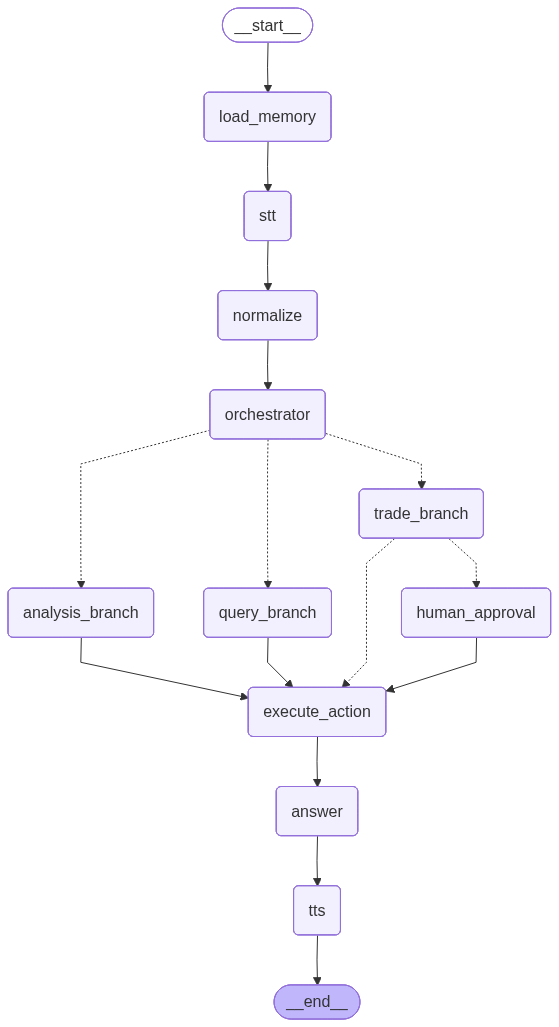

In [106]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

## 測試

In [107]:
async def demo():

    print("="*70)
    print("🚀 智能金融助理 - 完整語音對話")
    print("="*70 + "\n")

    # 情境 1: 簡單查詢（有 TTS）
    print("\n" + "="*70)
    print("📋 情境 1: 語音查詢 → 語音回覆")
    print("="*70)

    result = await graph.ainvoke({
        "user_id": "user_001",
        "audio_path": None,
        "raw_text": None,
        "normalized_text": None,
        "user_profile": None,
        "intent": None,
        "tool_results": None,
        "human_approved": None,
        "answer": None,
        "audio_output": None
    })

    print(f"\n📝 完整流程:")
    print(f"  🎤 語音輸入: {result['raw_text']}")
    print(f"  💬 文字回覆: {result['answer']}")
    print(f"  🔊 語音輸出: {result['audio_output']}")
    print(f"\n✅ 完成")

await demo()

🚀 智能金融助理 - 完整語音對話


📋 情境 1: 語音查詢 → 語音回覆
📚 載入記憶: 張三 (保守)


🎤 STT: 我想要買23304張。
📝 標準化: 我想要買23304張。


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🎯 意圖: trade
💰 執行交易分支
⚠️ 風險評估: ✅ 風險可控：投資 2330 金額 10,000 元在合理範圍

🤚 需要人工確認
用戶: 張三
風險評估:
✅ 風險可控：投資 2330 金額 10,000 元在合理範圍


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


是否批准？(y/n): y
✅ 人工批准


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



💬 文字回覆: 您好，已成功為您下單買入2330，金額10,000元。如有其他需求，歡迎隨時告知！

🔊 TTS 轉換中...
qqq
您好，已成功為您下單買入2330，金額10,000元。如有其他需求，歡迎隨時告知！



📝 完整流程:
  🎤 語音輸入: 我想要買23304張。
  💬 文字回覆: 您好，已成功為您下單買入2330，金額10,000元。如有其他需求，歡迎隨時告知！
  🔊 語音輸出: None

✅ 完成
